# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The Curse of Dimensionality
- High dimensional datasets are at risk of being very sparse: most training instances are likely to be far away from each other. 
- This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower dimensions, since they will be based on much larger extrapolations.
- In short, the **more dimensions** the training set has, the **greater the risk of overfitting** it.

# Main Approaches for Dimensionality Reduction
## Projection
- In most real-world problems, training instances are not spread out uniformly across all dimensions. 
- Many features are almost constant, while others are highly correlated, all training instances actually lie within (or close to) a **much lower-dimensional subspace** of the high-dimensional space.
- If we **project** every training instance perpendicularly **onto this subspace**, we reduce the dimensionality of the dataset.

## Manifold Learning
- However, projection is not always the best approach to dimensionality reduction. In many cases the **subspace may twist and turn**.
- More generally, a d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane.
- Many dimensionality reduction algorithms work by **modeling the manifold** on which the training instances lie; this is called **Manifold Learning**.

# Principal Component Analysis (PCA)
- PCA **identifies the hyperplane** that lies closest to the data, and then it **projects data onto it**.
- PCA defines the hyperplane by identifying the **principal components (PCs)**, which are **orthogonal** to each other and each accounts for the **largest amount of remaining variace**.
    - PCs can be found using a standard matrix factorization technique called **Singular Value Decomposition (SVD)**.
- Then the projection down to d dimensions can be done through the **matrix multiplication** of the **training set matrix** by the **matrix containing the first d principal components**.

## PCA using Scikit-Learn
- Scikit-Learn’s PCA class implements PCA using SVD decomposition.

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

- After fitting the PCA transformer to the dataset, you can access the principal components using the `components_` variable.

In [4]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

- The `explained_variance_ratio_` variable indicates the proportion of the dataset’s variance that lies along the axis of each principal component.

In [5]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

## Choosing the Right Number of Dimensions
- The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance.

In [6]:
pca = PCA()
pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.argmax(cumsum >= 0.95) + 1

2

- A better method is to set `n_components` to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve.

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(60, 2)

## PCA for Compression
- The following code compresses the MNIST dataset down to 154 dimensions, then uses the `inverse_transform()` method to decompress it back to 784 dimensions.

In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [9]:
from sklearn.model_selection import train_test_split

X = mnist['data']
y = mnist['target']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [11]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

In [12]:
X_recovered = pca.inverse_transform(X_reduced)

In [13]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

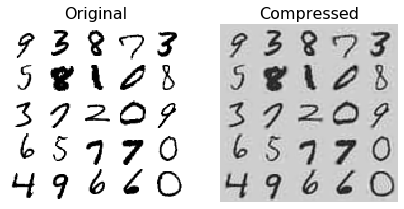

In [14]:
import matplotlib as mpl

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Randomized PCA
- If you set the **svd_solver** hyperparameter to **"randomized"**, Scikit-Learn uses a stochastic algorithm called **Randomized PCA** that quickly finds **an approximation of the first d principal components**.
- By default, svd_solver is actually set to **"auto"**: Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. 
    - If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to **"full"**.

In [15]:
pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = pca.fit_transform(X)
X_reduced.shape

(70000, 154)

## Incremental PCA
- One problem with the preceding implementations of PCA is that they require the whole training set to fit in memory in order for the algorithm to run. 
- Fortunately, **Incremental PCA (IPCA)** algorithms have been developed: you can **split the training set into mini-batches** and **feed an IPCA algorithm one mini-batch at a time**.

- The following code splits the MNIST dataset into 100 mini-batches (using NumPy’s `array_split()` function) and feeds them to Scikit-Learn’s **IncrementalPCA** class to reduce the dimensionality of the MNIST dataset down to 154 dimensions (just like before). 
    - Note that you must call the `partial_fit()` method with each mini-batch rather than the `fit()` method with the whole training set.

In [16]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
    print(".", end=" ")
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [17]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

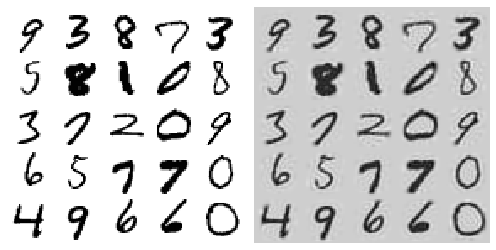

In [18]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

## Kernel PCA
- In Chapter 5 we discussed the **kernel trick**, a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines.
- The same trick can be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is called **Kernel PCA (kPCA)**.

- The following code uses Scikit-Learn’s **KernelPCA** class to perform **kPCA** with an **RBF kernel**.

In [19]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [20]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

- The following code uses KernelPCA to reduce the Swiss Roll to two dimensions using a **linear kernel** (equivalent to simply using the PCA class), an **RBF kernel**, and a **sigmoid kernel (Logistic)**.

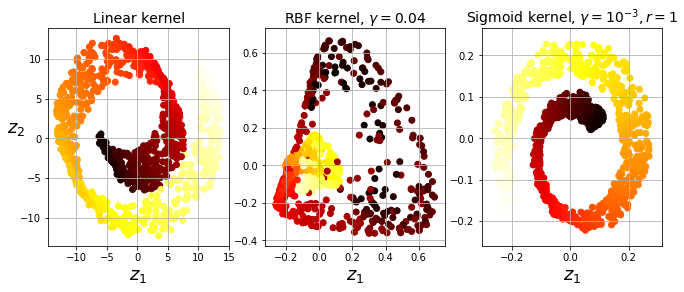

In [21]:
lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

### Selecting the Kernel and Hyperparameter Tuning
- Since kPCA is an **unsupervised learning** algorithm, there is no obvious performance measure to help you select the best kernel and hyperparameter values.
- However, we can simply use **grid search** to select the kernel and hyperparameters that lead to the best performance on the specific task of interest.

- The following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

param_grid = [{
    "kpca__gamma":np.linspace(0.03, 0.05, 10),
    "kpca__kernel":['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [23]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


- Another method to compute the **pre-image reconstruction error**, which is shown as below.
- Then we can use grid search to select the kernel and tune hyperparameters that minimize this error.

In [24]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)

X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [25]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

# LLE
- **Locally Linear Embedding (LLE)** is a nonlinear dimensionality reduction technique, a type of **manifold learning** technique.
- For each training instance $x_i$, it first reconstruct $x_i$ as a **linear function** of its **closest neighbors (c.n.)**, and then map it into a **low-dimensional space** while preserving these local relationships for as much as possible.

- The following code uses sklearn's **LocallyLinearEmbedding** class to unroll the Swiss Roll.

In [26]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)

X_reduced = lle.fit_transform(X)

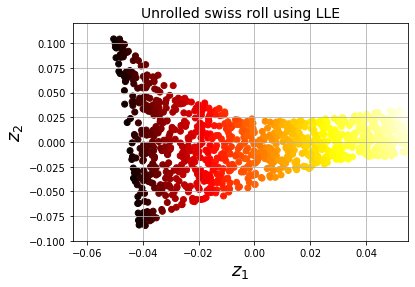

In [28]:
plt.title('Unrolled swiss roll using LLE', fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

# Other Dimensionality Reduction Techniques

## MDS
- **Multidimensional Scaling (MDS)** reduces dimensionality while trying to **preserve the distances between the instances**.

In [29]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

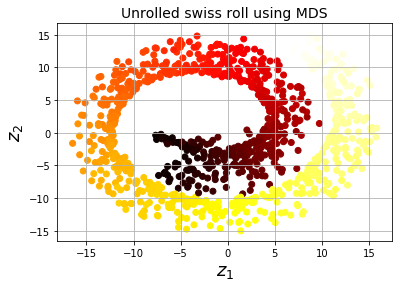

In [30]:
plt.title('Unrolled swiss roll using MDS', fontsize=14)
plt.scatter(X_reduced_mds[:, 0], X_reduced_mds[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

## Isomap
- Isomap creates a graph by **connecting each instance to its nearest neighbors**, then reduces dimensionality while trying to **preserve the geodesic distances** between the instances.

In [31]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

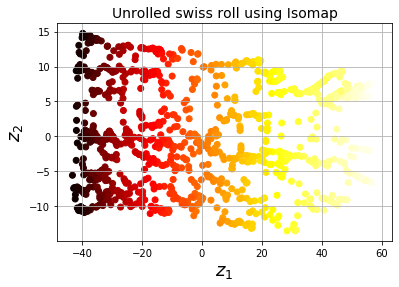

In [32]:
plt.title('Unrolled swiss roll using Isomap', fontsize=14)
plt.scatter(X_reduced_isomap[:, 0], X_reduced_isomap[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

## t_SNE
- **t-Distributed Stochastic Neighbor Embedding (t-SNE)** reduces dimensionality while trying to **keep similar instances close** and **dissimilar instances apart**.

In [33]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

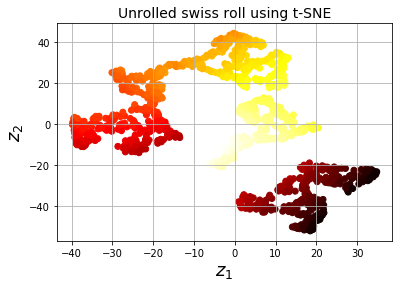

In [34]:
plt.title('Unrolled swiss roll using t-SNE', fontsize=14)
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

# Exercises

## 9. PCA and Random Forest

- Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [35]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [36]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

- Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.

In [37]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [38]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [39]:
print("Training took {:.2f}s".format(t1-t0))

Training took 39.29s


In [40]:
rnd_clf.score(X_test, y_test)

0.9705

- Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%.
- Train a new Random Forest classifier on the reduced dataset and see how long it takes.

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [42]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1-t0))

Training took 81.44s


- From above, we can see that training is **slower** after PCA.
- Well, as we saw in this chapter, **dimensionality reduction does not always lead to faster training time**: it depends on the dataset, the model and the training algorithm.
    - If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. 
- Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

In [43]:
X_test_reduced = pca.transform(X_test)

In [44]:
rnd_clf2.score(X_test_reduced, y_test)

0.9481

- From above, we can see that dimension reduction using PCA not only slowed the training but also led to a dropped performance.
- Now, let's try use **softmax regression**.

In [45]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1-t0))

Training took 8.46s


/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [46]:
log_clf.score(X_test, y_test)

0.9255

In [47]:
t0 = time.time()
log_clf.fit(X_train_reduced, y_train)
t1 = time.time()
print("Training took {:.2f}s".format(t1-t0))

Training took 2.94s


/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
log_clf.score(X_test_reduced, y_test)

0.9201

- As we can see, PCA successfully cuts training to about half with only a little drop in performance for Softmax regression.

## 10. t-SNE and Data Visualization

- Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. 
    - You can use a scatterplot using 10 different colors to represent each image’s target class. 
    - Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves.

In [49]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [50]:
from sklearn.manifold import TSNE
import time

t0 = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
t1 = time.time()

print("t-SNE took {:.1f}s.".format(t1-t0))

t-SNE took 171.5s.


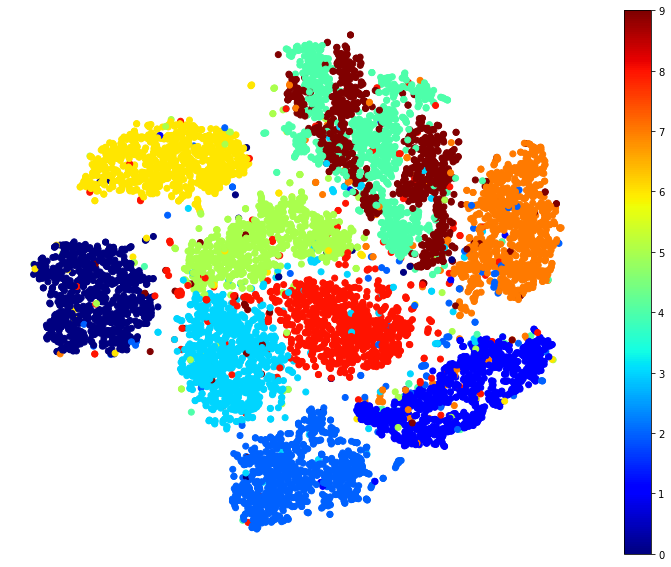

In [51]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()

- Now, let's focus on digits 3 and 5, which seem to overlap a lot.

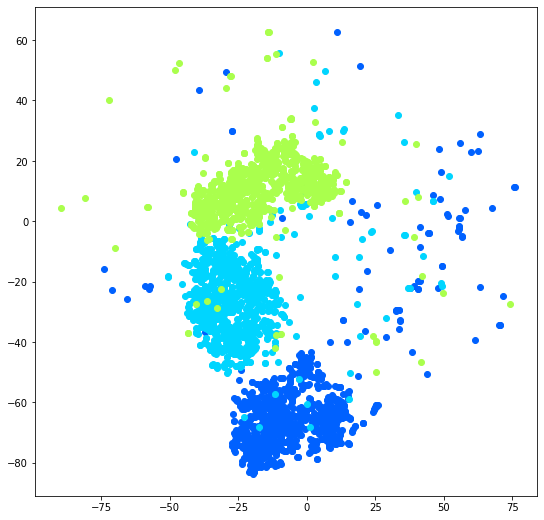

In [52]:
import matplotlib as mpl

plt.figure(figsize=(9, 9))
cmap = mpl.cm.get_cmap('jet')

for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit/9)])

- Now, let's see if we can produce a nicer image by running t-SNE on these digits.

In [53]:
idx = (y == 2) | (y == 3) | (y == 5)

X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

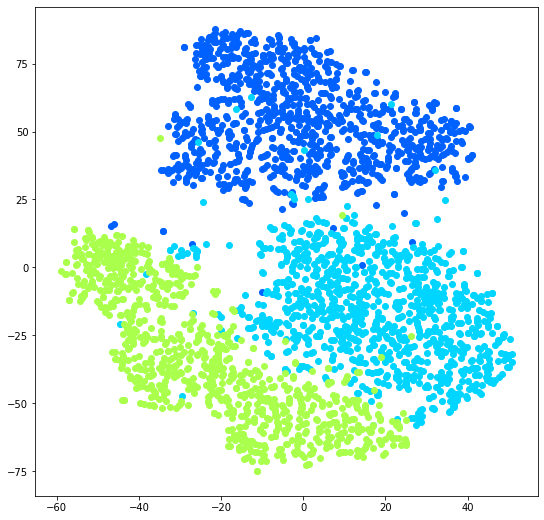

In [54]:
plt.figure(figsize=(9, 9))

for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit/9)])

- Let's create a `plot_digits()` function that will draw a scatterplot plus write colored digits, with a minimum distance guarnteed between these digits.
- If the digit images are provided, they are plotted instead.

In [55]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13,10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit/9)])
    plt.axis('off')
    ax = plt.gcf().gca()
    
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])), color=cmap(y[index]/9),
                        fontdict={'weight':'bold', 'size': 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'), image_coord)
                ax.add_artist(imagebox)

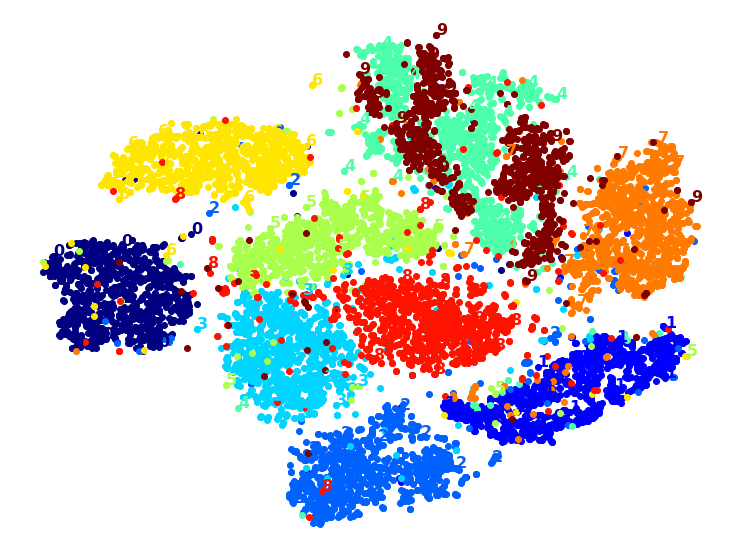

In [56]:
plot_digits(X_reduced, y)

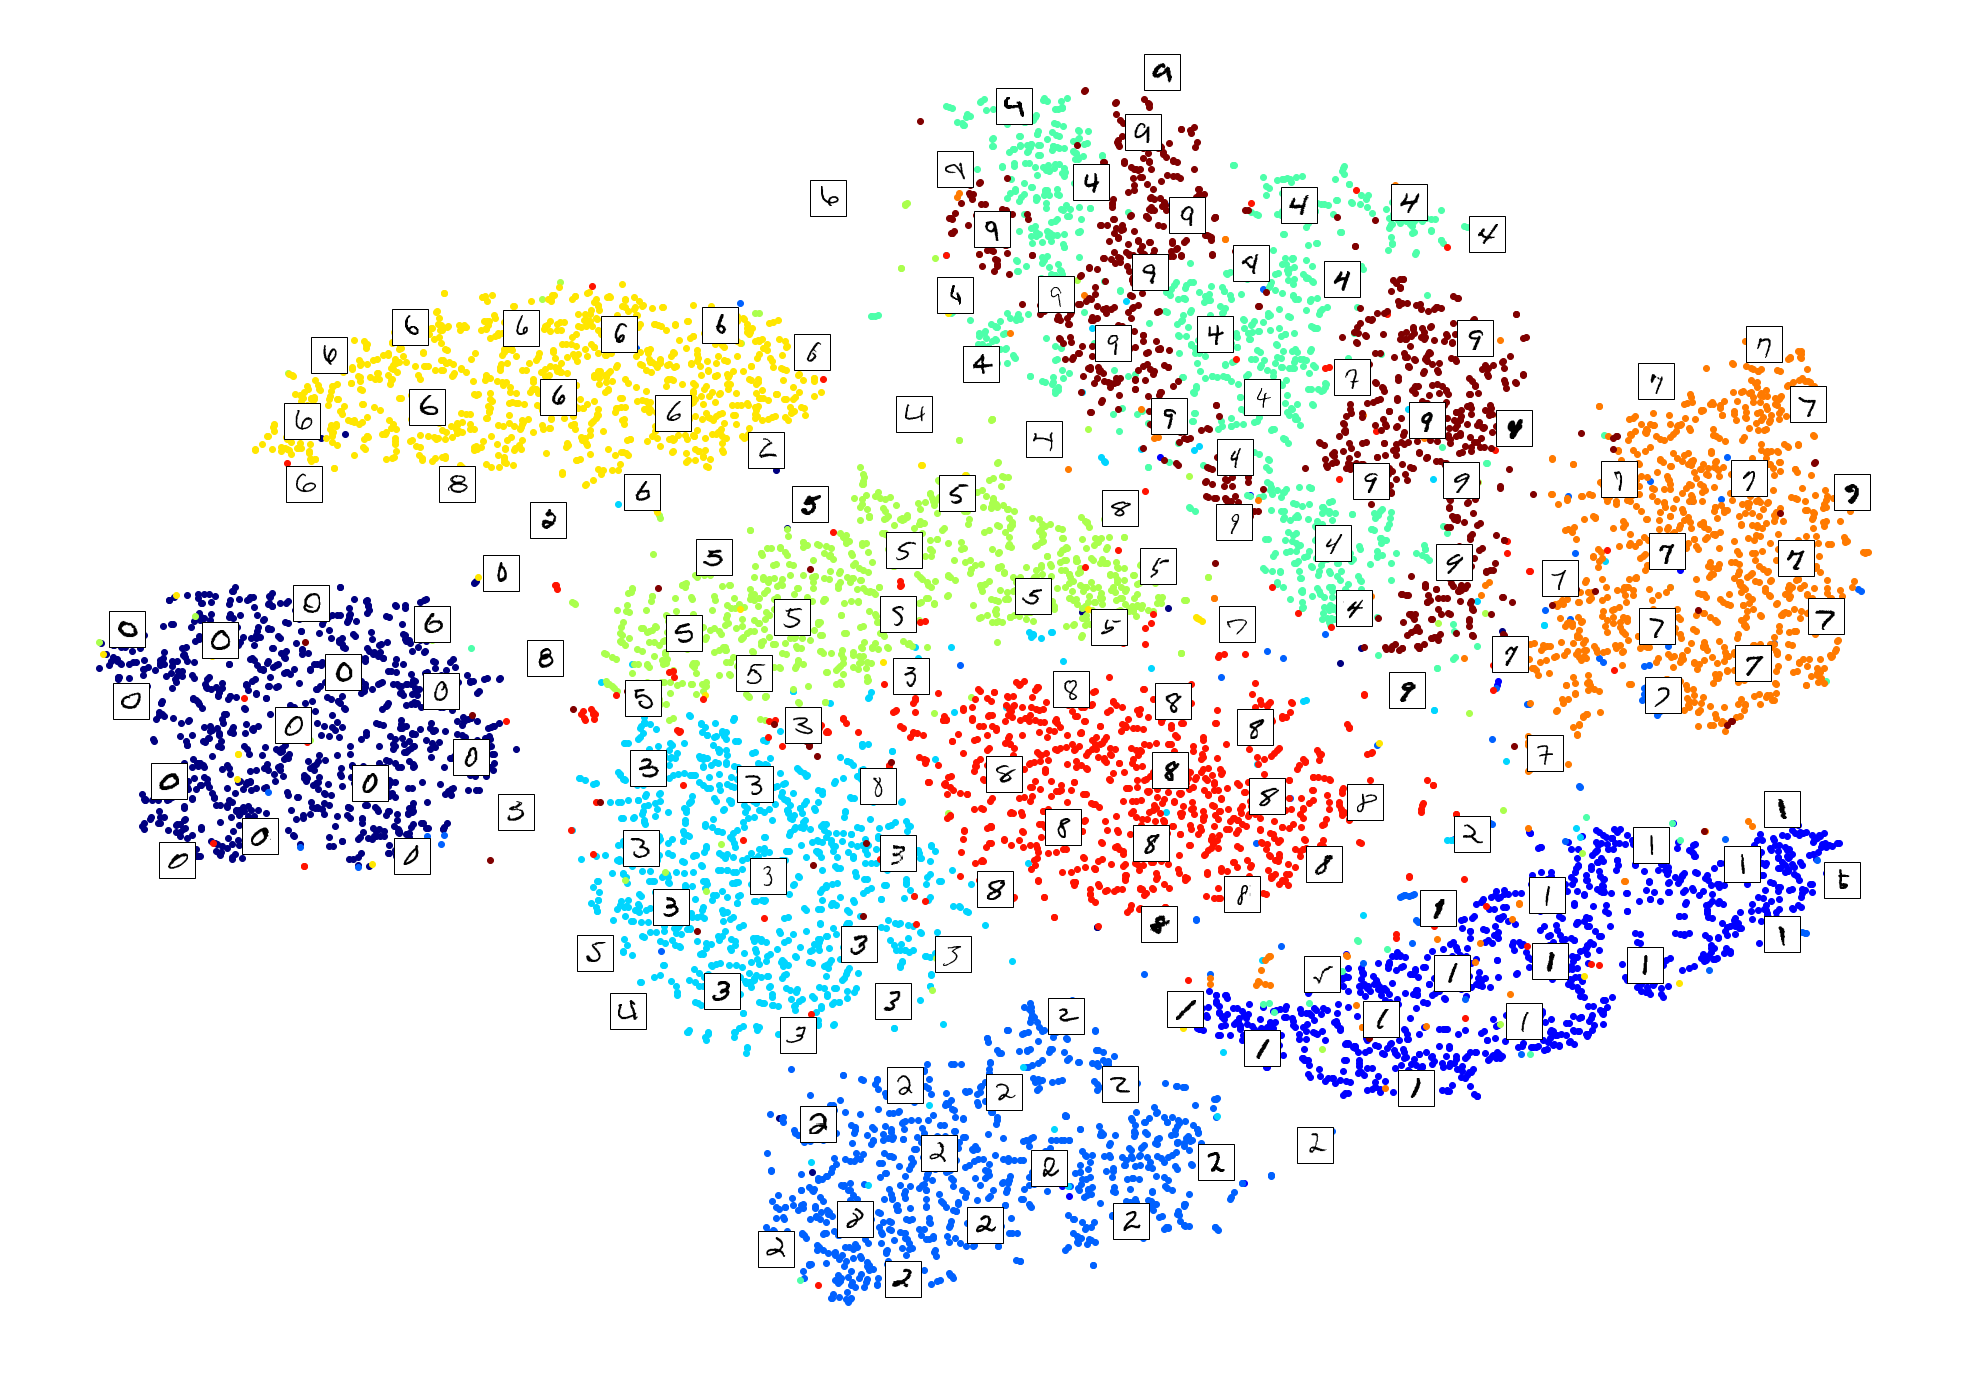

In [57]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

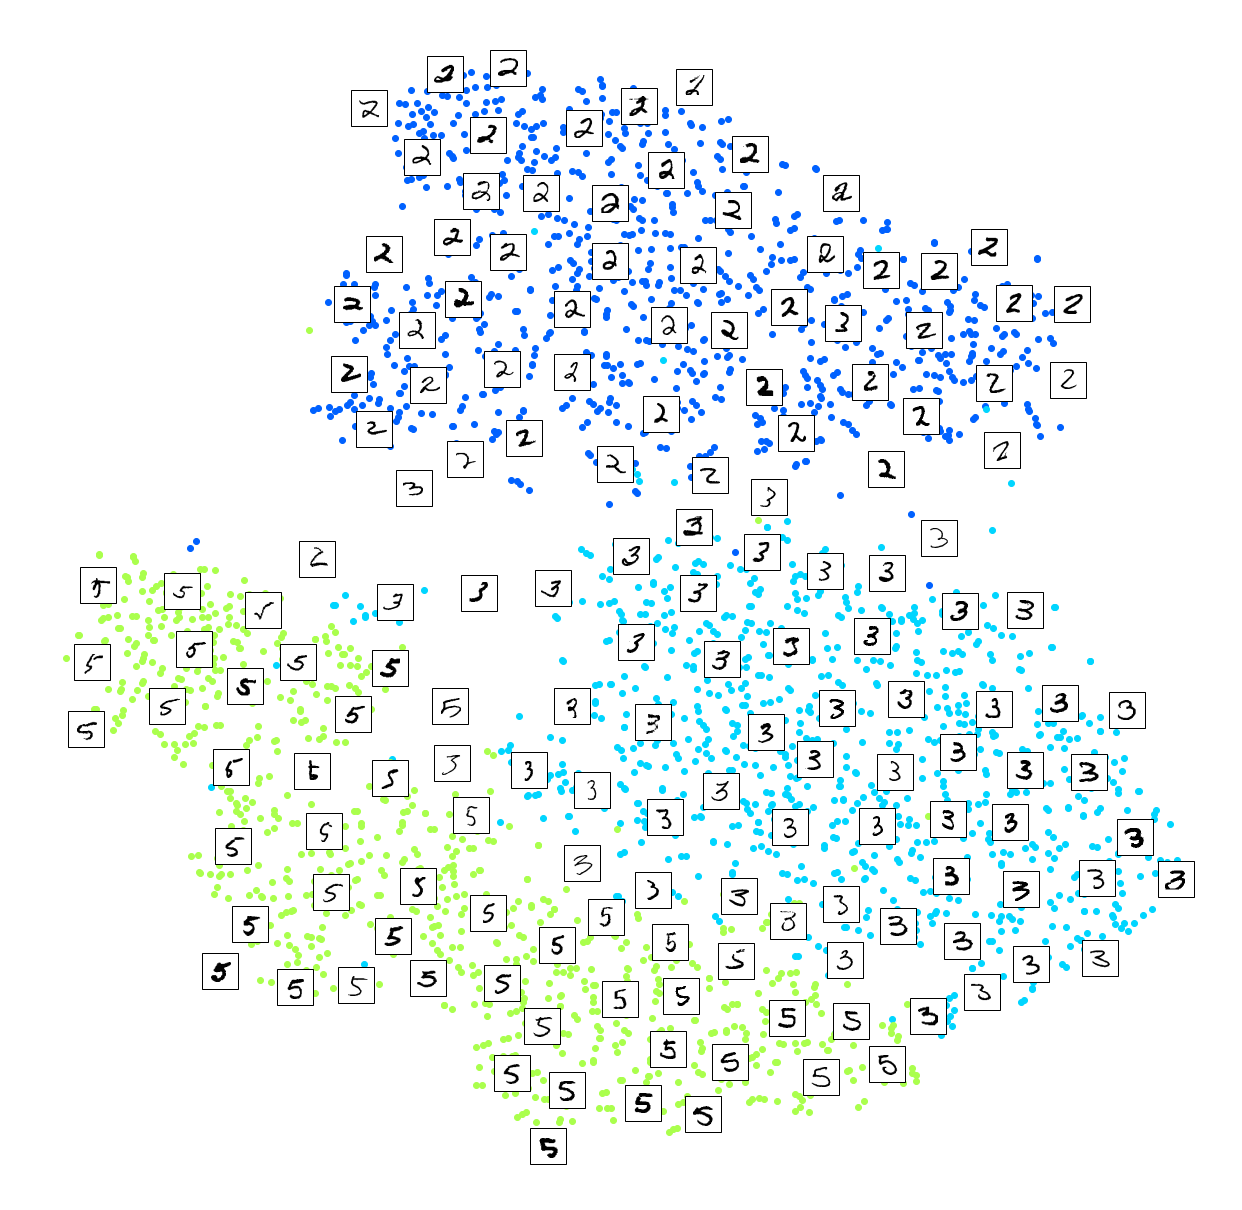

In [58]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

- Now, let's use PCA, LLE, and MDs, and compare the resulting visualizations.

PCA took 0.2s.


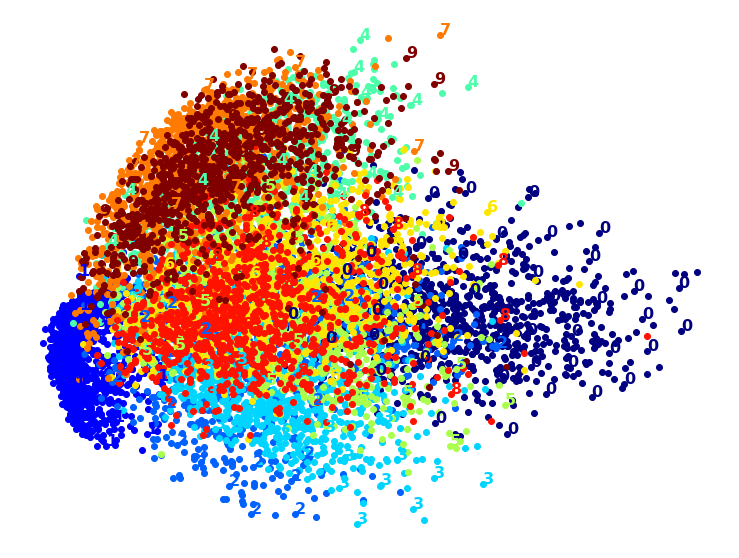

In [59]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1-t0))
plot_digits(X_pca_reduced, y)

LLE took 163.5s.


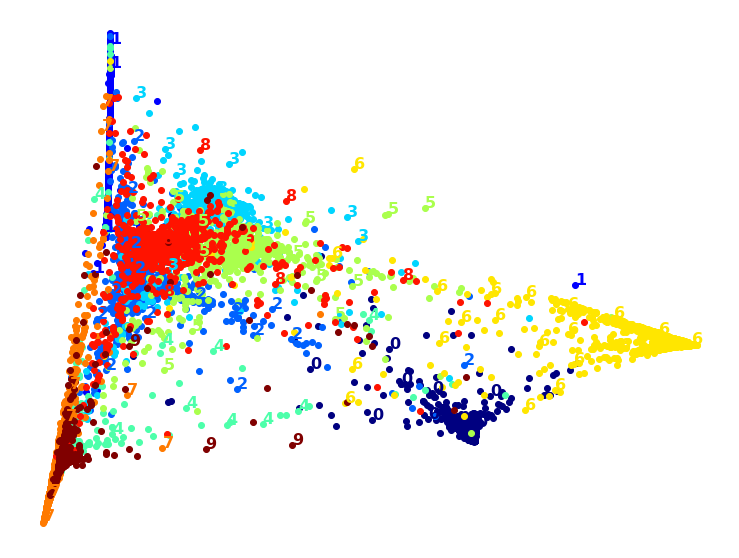

In [60]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1-t0))
plot_digits(X_lle_reduced, y)

- As seen from above, the result is not really good.
- Let's try create a pipline which applies PCA first, then fit the LLE.

PCA+LLE took 31.1s.


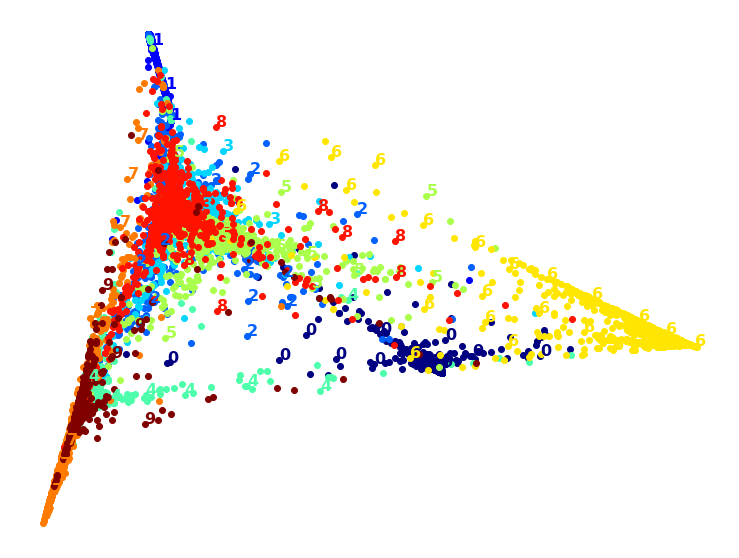

In [61]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print('PCA+LLE took {:.1f}s.'.format(t1-t0))
plot_digits(X_pca_lle_reduced, y)

- Let's try MDS. But instead of running it on 10000 instances, which takes a long time, let's run it on 2000 instances for now.

MDS took 74.1s (on just 2000 instances instead of 10000.


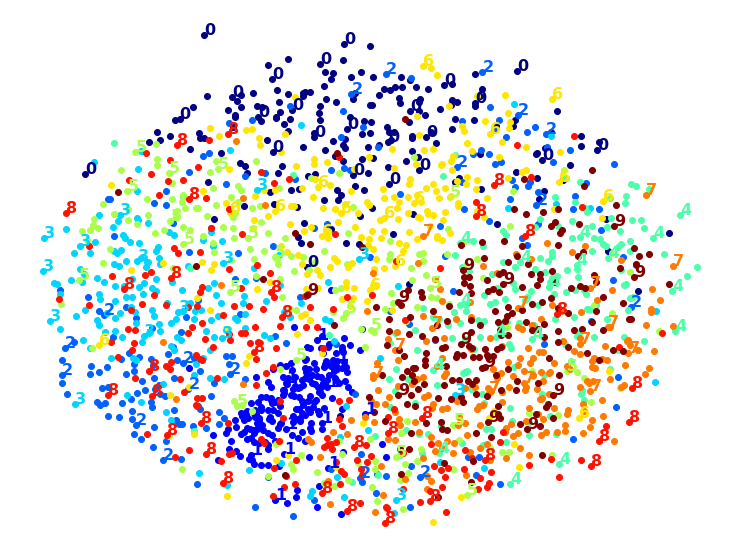

In [62]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2000 instances instead of 10000.".format(t1-t0))

plot_digits(X_mds_reduced, y[:m])

- Again, let's try PCA + MDS.

PCA+MDS took 74.1s (on 2000 instances).


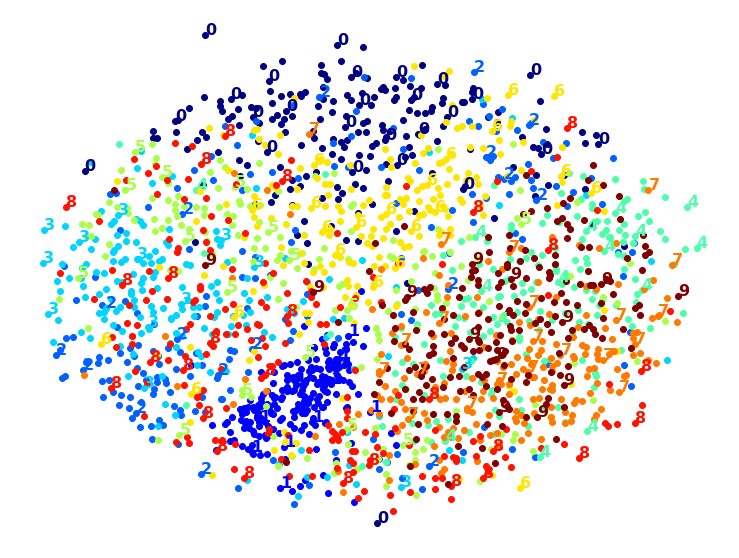

In [63]:
pca_mds = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('mds', MDS(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print('PCA+MDS took {:.1f}s (on 2000 instances).'.format(t1-t0))

plot_digits(X_pca_mds_reduced, y[:2000])

- Finally, let's try PCA+t-SNE.

PCA+MDS took 55.4s.


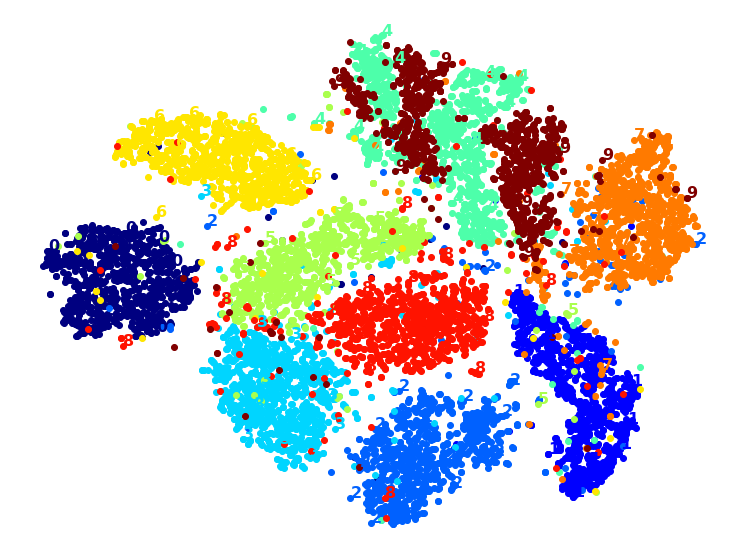

In [64]:
pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('tsne', TSNE(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print('PCA+MDS took {:.1f}s.'.format(t1-t0))

plot_digits(X_pca_tsne_reduced, y)

- From above, we can see that PCA roughly gave t-SNE a 25% speedup, without damaging the result.